In [1]:
import numpy as np
import tensorflow as tf
print("TF version =", tf.__version__)

TF version = 2.9.2


In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot

from tensorflow.keras import initializers
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import scipy.stats as stats

In [10]:
N = 252
S0 = 1
T = 1
strike = 0.8
sigma = 0.4
coupon = 0.12

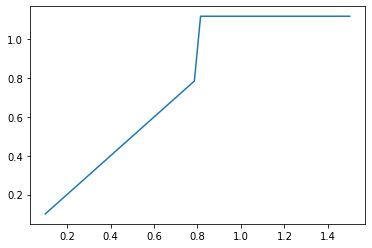

In [5]:
def payoff(x, strike, coupon):
    if len(x[0]) > 1:
        x = K.min(x, axis=1)
    b = K.greater_equal(x, strike)
    b = K.cast(b, "float32")
    return (1+coupon)*b + x*(1-b)

x = np.linspace(0.1, 1.5, 50).reshape((-1,1))

plt.plot(x, payoff(x, strike, coupon))

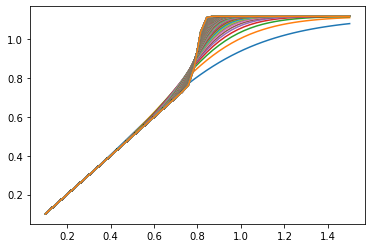

In [14]:
def cash_or_nothing_C(S, K, T, sigma):
    return stats.norm.cdf((np.log(S/K)+(-0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

def asset_or_nothing_P(S, K, T, sigma):
    return S*stats.norm.cdf(-(np.log(S/K)+(0.5*sigma**2)*T)/(sigma*np.sqrt(T)), 0, 1)

for i in range(N):
    plt.plot(x, (1+coupon)*cash_or_nothing_C(x, strike, T/(i+1), sigma) + asset_or_nothing_P(x, strike, T/(i+1), sigma))

In [ ]:
u = 1
m = 1
d = 3
n = 32

layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]


price = Input(shape=(u,))
hedge = Input(shape=(u,))
hedgeeval = Input(shape=(u,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper = []

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer=initializers.RandomNormal(0,0.1))(premium)

for j in range(N):
    strategy = price
    strategyeval = hedgeeval
    for k in range(d):
        strategy = layers[k+(j)*d](strategy)
        strategyeval = layers[k+(j)*d](strategyeval)
    incr = Input(shape=(u,))
    logprice = 